# Reinforcement Learning

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

import os

# OpenAI gym
import gym

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf

# Get smooth animations
mpl.rc('animation', html='jshtml')

physical_devices = tf.config.list_physical_devices('GPU')

if not physical_devices:
    print("No GPU was detected.")
else:
    # https://stackoverflow.com/a/60699372
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
from tensorflow import keras

No GPU was detected.


## Introduction to OpenAI gym

In [2]:
# List first few environments
list(gym.envs.registry.all())[:10]

[EnvSpec(Copy-v0),
 EnvSpec(RepeatCopy-v0),
 EnvSpec(ReversedAddition-v0),
 EnvSpec(ReversedAddition3-v0),
 EnvSpec(DuplicatedInput-v0),
 EnvSpec(Reverse-v0),
 EnvSpec(CartPole-v0),
 EnvSpec(CartPole-v1),
 EnvSpec(MountainCar-v0),
 EnvSpec(MountainCarContinuous-v0)]

In [3]:
# Make the CartPole (v1) environment
env = gym.make('CartPole-v1')

# Initialize the environment
#  - Note that `reset` returns the initial state/observation
env.seed(42)
obs = env.reset()

# An obesrvation in the CartPole environment consists of
#  1. cart's horizontal position
#  2. its velocity
#  3. the angle of the pole (0 = vertical)
#  4. the angular velocity
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [4]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [5]:
# Render the environment and return an image as a numpy array
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

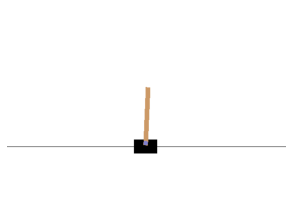

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img


plot_environment(env)
plt.show()

In [7]:
# Get available actions
env.action_space

Discrete(2)

In [8]:
# Accelerate right
action = 1

# Make single interaction with the environment
obs, reward, done, info = env.step(action)

obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

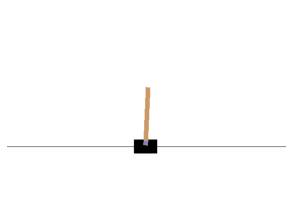

In [9]:
plot_environment(env)
plt.show()

In this environment the agent always receives a reward of 1. I.e. the goal is to play as long as possible (until `done == True`) - make the *episode* as long as possible.

In [10]:
reward

1.0

There is no info in this case but in general it can contain additional useful information such as number of lives or HP in a game.

In [11]:
info

{}

In [12]:
# One should always reset the enviroment after an episode
if done:
    obs = env.reset()

## A simple hard-coded policy

In [13]:
# Reset RNG state
env.seed(42)


def basic_policy(obs):
    """
    Naive policy that turns the cart left or right depending on 
    the direction current angle.
    """
    angle = obs[2]
    return 0 if angle < 0 else 1


def run_episode(env, policy, n_steps):
    """
    Execute single episode with given policy and 
    return accumulated reward.
    """
    episode_rewards = 0
    obs = env.reset()
    for step in range(n_steps):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            return episode_rewards
    return episode_rewards


# Hyperparameters
n_episodes = 500
n_steps = 200

# Collect total rewards from all episodes
totals = [run_episode(env, basic_policy, n_steps) for _ in range(n_episodes)]

# Show statistics of episodic rewards
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

This naive policy was able to keep the pole up for maximum of 68 episodes (reward 1 per episode => total reward is also the number of steps until done).

In [14]:
# Reset RNG state
env.seed(42)


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
    )
    plt.close()
    return anim
    

# Run single episode to collect all frames
frames = []
obs = env.reset()
for _ in range(n_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, _, done, _ = env.step(action)
    if done:
        break
        
# Visualize the episode
plot_animation(frames)